In [2]:
import sys

sys.path.append('/Users/mrx_qa/BigKindsParser/')

In [5]:
import BigKindsParser as bkp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

news_df = pd.read_excel("./inha_3month.xlsx", engine = 'openpyxl')

In [6]:
import gensim
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


news_words = bkp.keyword_parser(news_df['키워드'])

news_dict = gensim.corpora.Dictionary(news_words)
corpus = [news_dict.doc2bow(text) for text in news_words]


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
]) 

vec = pipeline.fit_transform(news_df['키워드']).toarray()

In [7]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=news_dict, num_topics = NUM_TOPICS, passes=run, iterations=ite, random_state=10)


def make_topictable(ldamodel, corpus):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0: 
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return(topic_table)

topictable = make_topictable(ldamodel, corpus)
topictable = topictable.reset_index() 
topictable.columns = ['뉴스 번호', '주요 토픽', '주요 토픽 비중', '토픽 별 비중']
inha_topic_df = pd.concat([news_df[['제목', '언론사', '키워드']], topictable['주요 토픽']], axis = 1)

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=400, init = "random").fit_transform(vec)

tsne_df = pd.DataFrame(tsne, columns = ['component 0', 'component 1'])

tsne_df = pd.concat([tsne_df, topictable['주요 토픽']], axis = 1)

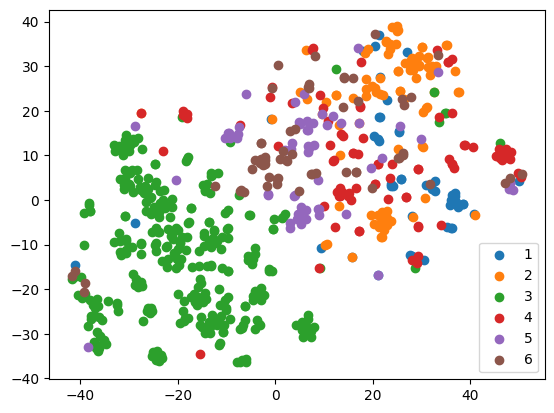

In [11]:
fig, ax = plt.subplots()

groups = tsne_df.groupby('주요 토픽')
for name, points in groups:
    ax.scatter(points['component 0'], points['component 1'], label=int(name) + 1)

ax.legend()

In [13]:
from sklearn.decomposition import TruncatedSVD

lsa_df = TruncatedSVD(n_components = 2).fit_transform(vec)

lsa_df = pd.DataFrame(lsa_df, columns = ['component 0', 'component 1'])

lsa_df = pd.concat([lsa_df, topictable['주요 토픽']], axis = 1)

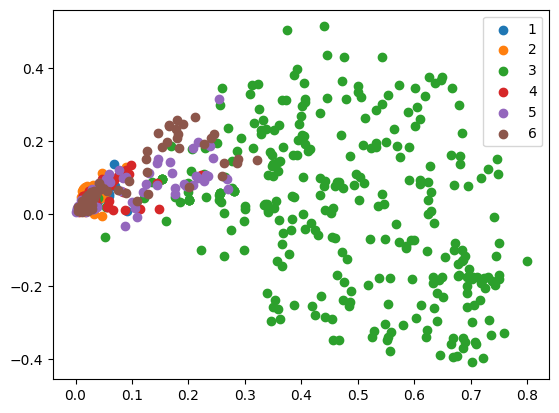

In [15]:
fig, ax = plt.subplots()

groups = lsa_df.groupby('주요 토픽')
for name, points in groups:
    ax.scatter(points['component 0'], points['component 1'], label=int(name) + 1)

ax.legend()